<a href="https://colab.research.google.com/github/vaishnav711/sopt/blob/main/RBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install category_encoders xgboost

     |████████████████████████████████| 86 kB 5.1 MB/s 


In [2]:
import numpy as np
import category_encoders as ce
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek, SMOTEENN
from matplotlib import pyplot
from google.colab import drive
from collections import Counter

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Function to split the data into train and test datasets and also to display the shapes of the same
def stratified_sampling(X, y, test_size):
  # Stratified sampling of X, y
  train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, stratify=y['lead_status_N'], random_state=123)

  print(train_X.shape, test_X.shape)
  print()
  print(f'Number of rows in Train dataset: {train_X.shape[0]}')
  print(train_y['lead_status_N'].value_counts())
  print()
  print(f'Number of rows in Test dataset: {test_X.shape[0]}')
  print(test_y['lead_status_N'].value_counts())
  return train_X, test_X, train_y, test_y

In [4]:
# Function to balance the imbalanced dataset using [SMOTETomek, SMOTEENN]
def balanced_sample(X, y, method):
  if method == 'SMOTETomek':
    # Balancing the dataset - using SMOTETomek
    smote_tomek = SMOTETomek(random_state=0)
    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
  if method == 'SMOTEENN':
    # Balancing the dataset - using SMOTETENN
    smote_enn = SMOTEENN(random_state=0)
    X_resampled, y_resampled = smote_enn.fit_resample(X, y)

  # Printing the distribution of y variable of resampled data
  print('Before resampling:\n', y['lead_status_N'].value_counts())
  print('After resampling:\n', y_resampled['lead_status_N'].value_counts())

  return X_resampled, y_resampled

In [5]:
# Function to predict from test_X and to display the classification report
def predict_test_data(test_X, test_y):
  # Make predictions for test data
  y_pred = model.predict(test_X)
  predictions = [round(value) for value in y_pred]

  # Displaying the classification report
  print(classification_report(test_y, predictions))

In [6]:
# Function to print the model performance metrics
def model_performance_metrics(model):
  # Retrieve performance metrics
  results = model.evals_result()
  epochs = len(results['validation_0']['error'])
  x_axis = range(0, epochs)
  # Plot log loss
  fig, ax = pyplot.subplots()
  ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
  ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
  ax.legend()
  pyplot.ylabel('Log Loss')
  pyplot.title('XGBoost Log Loss')
  pyplot.show()
  # Plot classification error
  fig, ax = pyplot.subplots()
  ax.plot(x_axis, results['validation_0']['error'], label='Train')
  ax.plot(x_axis, results['validation_1']['error'], label='Test')
  ax.legend()
  pyplot.ylabel('Classification Error')
  pyplot.title('XGBoost Classification Error')
  pyplot.show()

In [7]:
# Function to build XGB Classifier model
def XGB_Classifier_model(train_X, train_y, params):
  model = xgb.XGBClassifier(**params)
  eval_set = [(train_X, train_y), (test_X, test_y)]
  model.fit(train_X, train_y.values.ravel(), early_stopping_rounds=10, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
  return model

In [8]:
# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
fpath = r'/content/drive/MyDrive/RBS/temp.feather'
so_DF = pd.read_feather(fpath)

# Dataframe with lead_status == 'Open'
so_open_DF = so_DF.query("lead_status == 'Open'")

# Dataframe without lead_status as 'Open'
so_DF = so_DF.query("lead_status != 'Open'")

# No. of hours by which the lead was closed
#so_DF['lead_closed_hours'] = so_DF['modified_on'] - so_DF['created_on']
# lead_closed in hours
#so_DF['lead_closed_hours'] = so_DF['lead_closed_hours'].dt.seconds / 3600.0
#so_DF['lead_closed_hours'] = (so_DF['lead_closed_hours'] <= 72).astype(int)

#print(so_DF.shape)

In [ ]:
print('No. of nulls in the dataset: ', so_DF.isnull().values.sum())

print('\nNulls in individual columns:')
print(so_DF.isnull().sum())

No. of nulls in the dataset:  898715

Nulls in individual columns:
lead                              0
do_not_modify_row_checksum        0
do_not_modify_modified_on     70777
owner                             0
lead_source                     772
portfolio_id                  32521
created_on                        0
lead_closed_date                  0
modified_on                       0
rbs_bin                       19941
rbs_cin                       64148
merchant                         23
trading_name                  69178
legal_entity_type              6155
current_provider              46594
mcc_code                      70777
lead_status                       0
status_reason                     2
lead_id                       70777
referral_id                   24397
currently_taking_payments     39784
ad_content                    63793
campaign                      60321
keyword                       66994
landing_page                  60321
medium                        603

In [ ]:
# skip
col_names = list(so_DF.columns)
col_list = []
for cn in col_names:
  count = so_DF[cn].count()
  nunique = so_DF[cn].nunique()
  data_type = so_DF[cn].dtype

  cntuple = (cn, count, nunique)
  col_list.append(cntuple)
  print(cntuple)

In [10]:
col_list = [('lead', 71138, 71138, True), ('do_not_modify_row_checksum', 71138, 71138, False), ('do_not_modify_modified_on', 0, 0, False), ('owner', 71138, 89, False),
 ('lead_source', 70302, 9, True), ('portfolio_id', 38369, 1744, False), ('created_on', 71138, 66250, False), ('lead_closed_date', 70777, 807, False),
 ('modified_on', 71138, 52484, False), ('rbs_bin', 51020, 44817, False), ('rbs_cin', 6642, 6492, False), ('merchant', 71113, 66278, False), ('trading_name', 1653, 1624, False),
 ('legal_entity_type', 64954, 10, True), ('current_provider', 24271, 26, True), ('mcc_code', 0, 0, False), ('lead_status', 71138, 3, True), ('status_reason', 71136, 30, True),
 ('lead_id', 0, 0, False), ('referral_id', 46537, 42687, False), ('currently_taking_payments', 31098, 3, True), ('ad_content', 6993, 140, True), ('campaign', 10470, 91, True),
 ('keyword', 3784, 320, True), ('landing_page', 10470, 16, True), ('medium', 10470, 26, True), ('source', 10468, 21, True), ('banked_customer', 60299, 3, True)]


col_selected = []
cn_selected = []
for cl in col_list:
  if cl[3] == True:
    col_selected.append(cl)
    cn_selected.append(cl[0])
print(col_selected)

# Selecting the required columns
so_DF = so_DF[cn_selected]

[('lead', 71138, 71138, True), ('lead_source', 70302, 9, True), ('legal_entity_type', 64954, 10, True), ('current_provider', 24271, 26, True), ('lead_status', 71138, 3, True), ('status_reason', 71136, 30, True), ('currently_taking_payments', 31098, 3, True), ('ad_content', 6993, 140, True), ('campaign', 10470, 91, True), ('keyword', 3784, 320, True), ('landing_page', 10470, 16, True), ('medium', 10470, 26, True), ('source', 10468, 21, True), ('banked_customer', 60299, 3, True)]


In [11]:
#print(so_DF.shape)
#so_DF = so_DF.replace(to_replace='None', value=np.nan).dropna()
#so_DF = so_DF.dropna(axis=0, how='any')

so_DF = so_DF.replace(to_replace=np.nan, value='Unknown')
so_DF = so_DF.replace(to_replace='NULL', value='Unknown')
#print(so_DF.shape)

print('Columns after handling nulls')
print(so_DF.isnull().sum())

Columns after handling nulls
lead                         0
lead_source                  0
legal_entity_type            0
current_provider             0
lead_status                  0
status_reason                0
currently_taking_payments    0
ad_content                   0
campaign                     0
keyword                      0
landing_page                 0
medium                       0
source                       0
banked_customer              0
dtype: int64


In [ ]:
cn_selected

In [ ]:
so_DF['lead_status'].value_counts()

Qualified       56832
Disqualified    13945
Name: lead_status, dtype: int64

In [ ]:
col_names = list(so_DF.columns)

# Displaying selected columns
for cn in col_names:
  count = so_DF[cn].count()
  nunique = so_DF[cn].nunique()
  data_type = so_DF[cn].dtype

  #if_cndt = (count > 0) and (count != nunique) and (data_type != 'datetime64[ns, UTC]')
  #if if_cndt:
  cntuple = (cn, count, nunique)
  print(cntuple)

('lead', 70777, 70777)
('lead_source', 70777, 10)
('legal_entity_type', 70777, 11)
('current_provider', 70777, 26)
('lead_status', 70777, 2)
('status_reason', 70777, 30)
('currently_taking_payments', 70777, 3)
('ad_content', 70777, 141)
('campaign', 70777, 92)
('keyword', 70777, 321)
('landing_page', 70777, 17)
('medium', 70777, 27)
('source', 70777, 22)
('banked_customer', 70777, 3)


###Encoding categorical columns

In [12]:
# Label Encoding y variable
le = LabelEncoder()
so_DF['lead_status_N'] = le.fit_transform(so_DF['lead_status'].values)

X_var = ['lead_source', 'legal_entity_type', 'current_provider', 'status_reason', 'currently_taking_payments', 'ad_content', 'campaign', 'keyword', 'landing_page', 'medium', 'source', 'banked_customer']
y_var = ['lead_status_N']
X = so_DF[X_var]
y = so_DF[y_var]

# Binary Encoding X variables
ce_be = ce.BinaryEncoder(cols = X_var)
X = ce_be.fit_transform(X, y['lead_status_N'])


###Modelling with stratified sample of the data

In [ ]:
# Stratified sampling of X, y
train_X, test_X, train_y, test_y = stratified_sampling(X, y, test_size=0.3)

(49543, 61) (21234, 61)

Number of rows in Train dataset: 49543
1    39782
0     9761
Name: lead_status_N, dtype: int64

Number of rows in Test dataset: 21234
1    17050
0     4184
Name: lead_status_N, dtype: int64


In [ ]:
%%time
params = {'max_depth': int(4), 'subsample': 0.9, 'objective': 'binary:logistic', 'n_estimators': 200, 'learning_rate': 0.1}
model = XGB_Classifier_model(train_X, train_y, params)

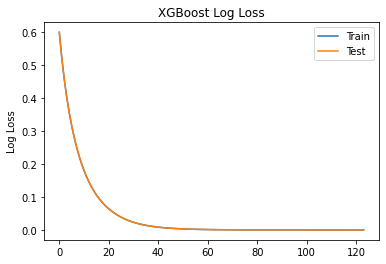

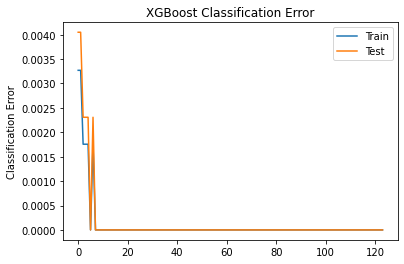

In [ ]:
model_performance_metrics(model)

In [ ]:
predict_test_data(test_X, test_y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4184
           1       1.00      1.00      1.00     17050

    accuracy                           1.00     21234
   macro avg       1.00      1.00      1.00     21234
weighted avg       1.00      1.00      1.00     21234



###Modelling with balanced data

Balancing the data using SMOTETomek - Over-sampling using SMOTE and cleaning using Tomek links. Combine over- and under-sampling using SMOTE and Tomek links.

In [ ]:
X_resampled, y_resampled = balanced_sample(X, y, method='SMOTETomek')

Before resampling:
 1    56832
0    13945
Name: lead_status_N, dtype: int64
After resampling:
 1    56818
0    56818
Name: lead_status_N, dtype: int64


In [ ]:
# Stratified sampling of X, y
train_X, test_X, train_y, test_y = stratified_sampling(X_resampled, y_resampled, test_size=0.3)

(79545, 61) (34091, 61)

Number of rows in Train dataset: 79545
1    39773
0    39772
Name: lead_status_N, dtype: int64

Number of rows in Test dataset: 34091
0    17046
1    17045
Name: lead_status_N, dtype: int64


In [ ]:
%%time
params = {'max_depth': int(4), 'subsample': 0.9, 'objective': 'binary:logistic', 'n_estimators': 200, 'learning_rate': 0.1}
model = XGB_Classifier_model(train_X, train_y, params)

In [ ]:
model_performance_metrics(model)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17046
           1       1.00      1.00      1.00     17045

    accuracy                           1.00     34091
   macro avg       1.00      1.00      1.00     34091
weighted avg       1.00      1.00      1.00     34091



In [ ]:
predict_test_data(test_X, test_y)

SMOTEENN - Over-sampling using SMOTE and cleaning using ENN. Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours.

In [ ]:
X_resampled, y_resampled = balanced_sample(X, y, method='SMOTEENN')

Before resampling:
 1    56832
0    13945
Name: lead_status_N, dtype: int64
After resampling:
 1    56568
0    56249
Name: lead_status_N, dtype: int64


In [ ]:
# Stratified sampling of X, y
train_X, test_X, train_y, test_y = stratified_sampling(X_resampled, y_resampled, test_size=0.3)

In [ ]:
%%time
params = {'max_depth': int(4), 'subsample': 0.9, 'objective': 'binary:logistic', 'n_estimators': 200, 'learning_rate': 0.1}
model = XGB_Classifier_model(train_X, train_y, params)

In [ ]:
model_performance_metrics(model)

In [ ]:
predict_test_data(test_X, test_y)

In [ ]:
confusion_matrix(predictions, test_y)

array([[17014,     3],
       [   27, 17038]])